In [1]:
# import necessary tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from sklearn.decomposition import PCA

In [2]:
# load the data
df=pd.read_csv('CC GENERAL.csv')

# data overview
df.sample(8)

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
7933  C18148     0.000000           0.000000     136.80              0.00   
454   C10472  1207.888199           0.875000    1342.36           1037.96   
8841  C19082   150.560510           0.833333     368.34            368.34   
2998  C13087  1201.149593           1.000000     851.21            260.45   
5516  C15671   182.854647           1.000000    1978.87            765.85   
5289  C15438  1903.274531           0.545455    1813.40              0.00   
987   C11021  3421.547800           1.000000      36.00              0.00   
6337  C16512    50.571196           0.545455     499.98              0.00   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
7933                  136.80      0.000000             1.000000   
454                   304.40   1738.109478             0.875000   
8841                    0.00      0.000000             0.500000   
2998                  590.76      0.000000             0.833333   
5516                 1213.02      0.000000             1.000000   
5289                 1813.40   3795.101004             0.500000   
987                    36.00     19.042417             0.083333   
6337                  499.98      0.000000             0.500000   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
7933                       0.000                          1.000000   
454                        0.875                          0.500000   
8841                       0.500                          0.000000   
2998                       0.250                          0.750000   
5516                       0.750                          1.000000   
5289                       0.000                          0.416667   
987                        0.000                          0.083333   
6337                       0.000                          0.416667   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
7933                0.000000                 0             12        2700.0   
454                 0.250000                 2             27        4000.0   
8841                0.000000                 0              4        1200.0   
2998                0.000000                 0             21        3600.0   
5516                0.000000                 0             68        6000.0   
5289                0.083333                 1             14        4000.0   
987                 0.083333                 1              1        3500.0   
6337                0.000000                 0              6        2500.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
7933   127.996550               NaN              0.00      12  
454    288.883026        312.026316              0.00       8  
8841    68.244473         85.170836              0.00       6  
2998   978.569968        362.836640              0.00      12  
5516  1590.330808        167.136534              0.75      12  
5289  1959.916433       1187.591705              0.00      12  
987    404.993426      10849.438090              0.00      12  
6337   744.260461        235.440351              0.20      12

### List of columns from the dataframe:

    # BALANCE : Balance amount left in their account to make purchases
    # BALANCE_FREQUENCY : How frequently the Balance is updated, score between 0 and 1 
                    # (1 = frequently updated, 0 = not frequently updated)
    # PURCHASES : Amount of purchases made from account
    # ONEOFF_PURCHASES : Maximum purchase amount done in one-go
    # INSTALLMENTS_PURCHASES : Amount of purchase done in installment
    # CASH_ADVANCE : Cash in advance given by the user
    # PURCHASES_FREQUENCY : How frequently the Purchases are being made, score between 0 and 1 
                         # (1 = frequently purchased, 0 = not frequently purchased)
    # ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go 
                                # (1 = frequently purchased, 0 = not frequently purchased)
    # PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done 
                                    # (1 = frequently done, 0 = not frequently done)
    # CASH_ADVANCE_FREQUENCY : How frequently the cash in advance being paid
    # CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"
    # PURCHASES_TRX : Number of purchase transactions made
    # CREDIT_LIMIT:  Limit of Credit Card for user
    # PAYMENTS : Amount of Payment done by user
    # MINIMUM_PAYMENTS : Minimum amount of payments made by user
    # PRCFULLPAYMENT : Percent of full payment paid by user
    # TENURE : Tenure of credit card service for user

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [4]:
df.describe().T

count         mean          std        min  \
BALANCE                           8950.0  1564.474828  2081.531879   0.000000   
BALANCE_FREQUENCY                 8950.0     0.877271     0.236904   0.000000   
PURCHASES                         8950.0  1003.204834  2136.634782   0.000000   
ONEOFF_PURCHASES                  8950.0   592.437371  1659.887917   0.000000   
INSTALLMENTS_PURCHASES            8950.0   411.067645   904.338115   0.000000   
CASH_ADVANCE                      8950.0   978.871112  2097.163877   0.000000   
PURCHASES_FREQUENCY               8950.0     0.490351     0.401371   0.000000   
ONEOFF_PURCHASES_FREQUENCY        8950.0     0.202458     0.298336   0.000000   
PURCHASES_INSTALLMENTS_FREQUENCY  8950.0     0.364437     0.397448   0.000000   
CASH_ADVANCE_FREQUENCY            8950.0     0.135144     0.200121   0.000000   
CASH_ADVANCE_TRX                  8950.0     3.248827     6.824647   0.000000   
PURCHASES_TRX                     8950.0    14.709832    24.857649   0.000000   
CREDIT_LIMIT                      8949.0  4494.449450  3638.815725  50.000000   
PAYMENTS                          8950.0  1733.143852  2895.063757   0.000000   
MINIMUM_PAYMENTS                  8637.0   864.206542  2372.446607   0.019163   
PRC_FULL_PAYMENT                  8950.0     0.153715     0.292499   0.000000   
TENURE                            8950.0    11.517318     1.338331   6.000000   

                                          25%          50%          75%  \
BALANCE                            128.281915   873.385231  2054.140036   
BALANCE_FREQUENCY                    0.888889     1.000000     1.000000   
PURCHASES                           39.635000   361.280000  1110.130000   
ONEOFF_PURCHASES                     0.000000    38.000000   577.405000   
INSTALLMENTS_PURCHASES               0.000000    89.000000   468.637500   
CASH_ADVANCE                         0.000000     0.000000  1113.821139   
PURCHASES_FREQUENCY                  0.083333     0.500000     0.916667   
ONEOFF_PURCHASES_FREQUENCY           0.000000     0.083333     0.300000   
PURCHASES_INSTALLMENTS_FREQUENCY     0.000000     0.166667     0.750000   
CASH_ADVANCE_FREQUENCY               0.000000     0.000000     0.222222   
CASH_ADVANCE_TRX                     0.000000     0.000000     4.000000   
PURCHASES_TRX                        1.000000     7.000000    17.000000   
CREDIT_LIMIT                      1600.000000  3000.000000  6500.000000   
PAYMENTS                           383.276166   856.901546  1901.134317   
MINIMUM_PAYMENTS                   169.123707   312.343947   825.485459   
PRC_FULL_PAYMENT                     0.000000     0.000000     0.142857   
TENURE                              12.000000    12.000000    12.000000   

                                          max  
BALANCE                           19043.13856  
BALANCE_FREQUENCY                     1.00000  
PURCHASES                         49039.57000  
ONEOFF_PURCHASES                  40761.25000  
INSTALLMENTS_PURCHASES            22500.00000  
CASH_ADVANCE                      47137.21176  
PURCHASES_FREQUENCY                   1.00000  
ONEOFF_PURCHASES_FREQUENCY            1.00000  
PURCHASES_INSTALLMENTS_FREQUENCY      1.00000  
CASH_ADVANCE_FREQUENCY                1.50000  
CASH_ADVANCE_TRX                    123.00000  
PURCHASES_TRX                       358.00000  
CREDIT_LIMIT                      30000.00000  
PAYMENTS                          50721.48336  
MINIMUM_PAYMENTS                  76406.20752  
PRC_FULL_PAYMENT                      1.00000  
TENURE                               12.00000

# data cleaning

In [5]:
dtypes = pd.DataFrame(df.dtypes,columns=["Data Type"])

dtypes["Unique Values"]=df.nunique()

dtypes["Null Values"]=df.isnull().sum()

dtypes["% null Values"]=df.isnull().sum()/len(df)

dtypes.sort_values(by="Null Values" , ascending=False)

Data Type  Unique Values  Null Values  \
MINIMUM_PAYMENTS                   float64           8636          313   
CREDIT_LIMIT                       float64            205            1   
CUST_ID                             object           8950            0   
BALANCE                            float64           8871            0   
PRC_FULL_PAYMENT                   float64             47            0   
PAYMENTS                           float64           8711            0   
PURCHASES_TRX                        int64            173            0   
CASH_ADVANCE_TRX                     int64             65            0   
CASH_ADVANCE_FREQUENCY             float64             54            0   
PURCHASES_INSTALLMENTS_FREQUENCY   float64             47            0   
ONEOFF_PURCHASES_FREQUENCY         float64             47            0   
PURCHASES_FREQUENCY                float64             47            0   
CASH_ADVANCE                       float64           4323            0   
INSTALLMENTS_PURCHASES             float64           4452            0   
ONEOFF_PURCHASES                   float64           4014            0   
PURCHASES                          float64           6203            0   
BALANCE_FREQUENCY                  float64             43            0   
TENURE                               int64              7            0   

                                  % null Values  
MINIMUM_PAYMENTS                       0.034972  
CREDIT_LIMIT                           0.000112  
CUST_ID                                0.000000  
BALANCE                                0.000000  
PRC_FULL_PAYMENT                       0.000000  
PAYMENTS                               0.000000  
PURCHASES_TRX                          0.000000  
CASH_ADVANCE_TRX                       0.000000  
CASH_ADVANCE_FREQUENCY                 0.000000  
PURCHASES_INSTALLMENTS_FREQUENCY       0.000000  
ONEOFF_PURCHASES_FREQUENCY             0.000000  
PURCHASES_FREQUENCY                    0.000000  
CASH_ADVANCE                           0.000000  
INSTALLMENTS_PURCHASES                 0.000000  
ONEOFF_PURCHASES                       0.000000  
PURCHASES                              0.000000  
BALANCE_FREQUENCY                      0.000000  
TENURE                                 0.000000

In [6]:
# 'CUST_ID' is a feature with unique id for each customer, I'll drop it:
df.drop('CUST_ID', axis=1, inplace=True)

## Data cleaning - dealing with missing values

In [7]:
# impute missing values with KNNImputer
imputer = imputer = KNNImputer()
imputed = imputer.fit_transform(df)
df = pd.DataFrame(imputed, columns=df.columns)

In [8]:
# double check missing values
df.isna().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

# Exploratory Data Analysis

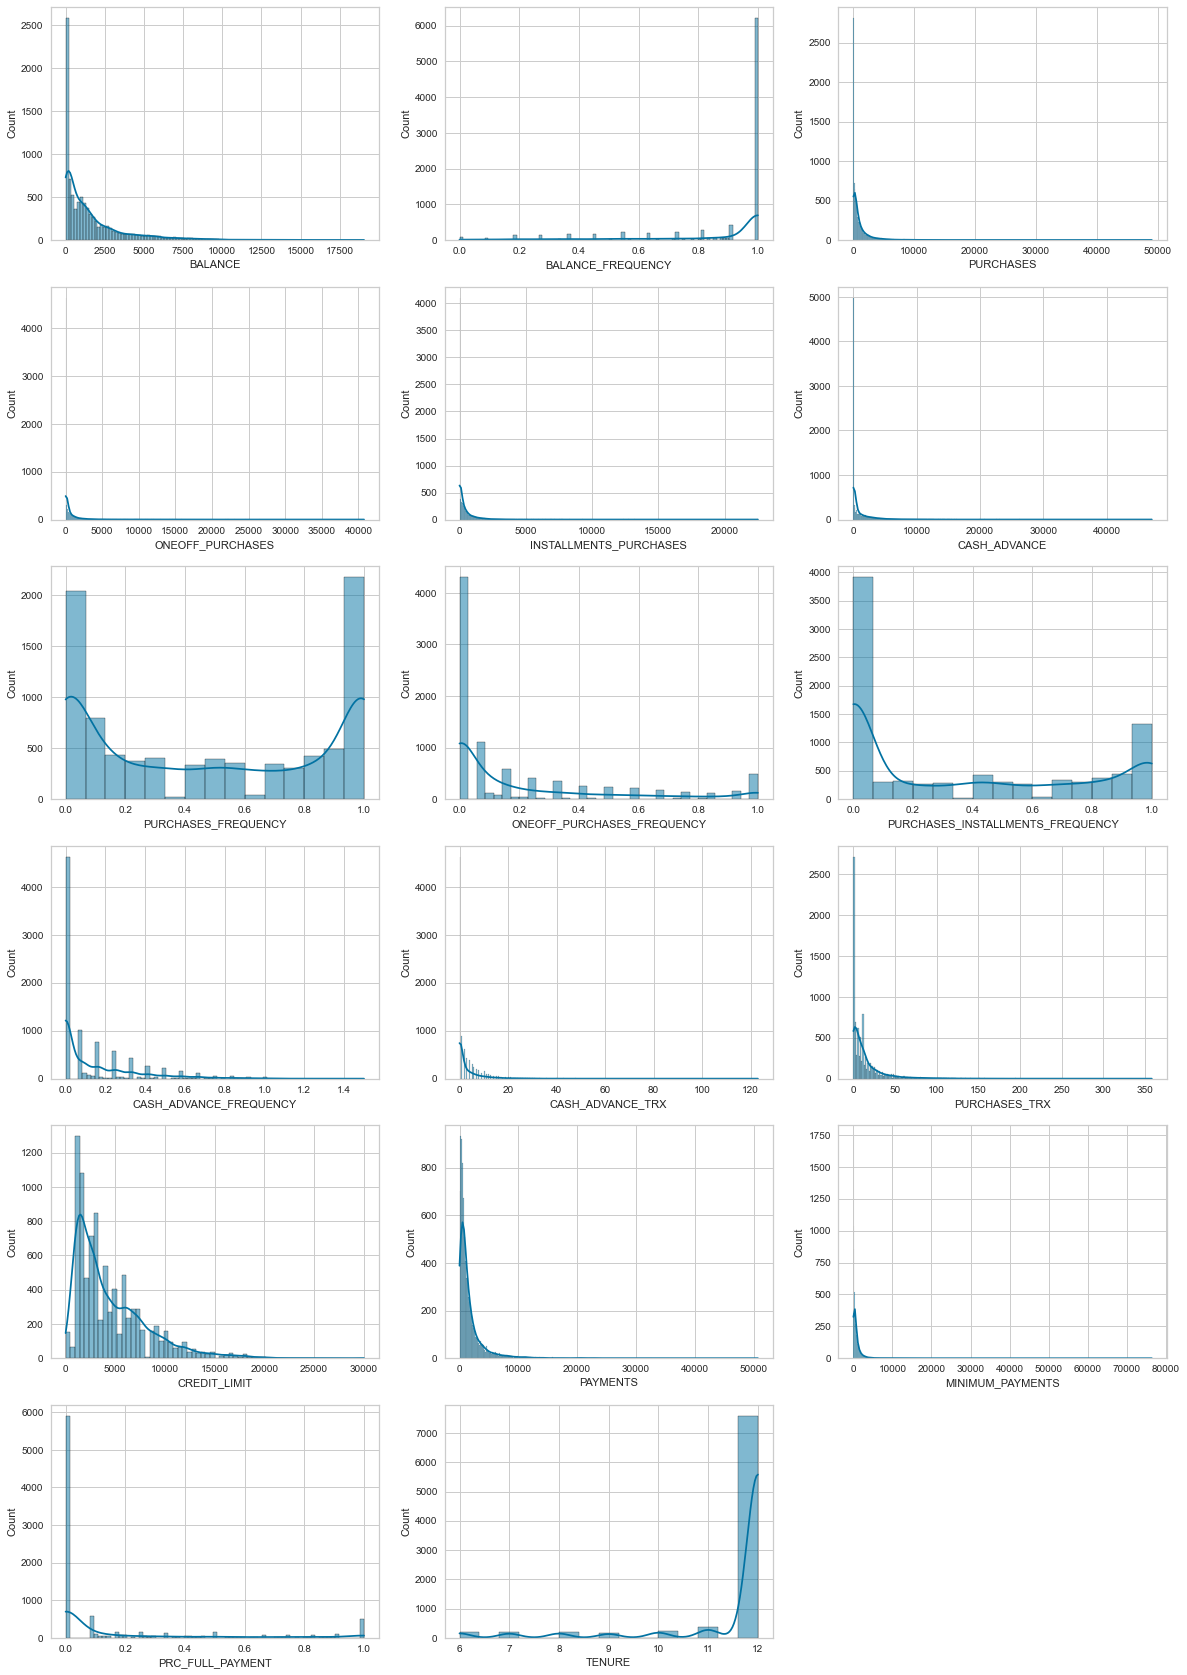

In [9]:
# Let's check the distributions of our features

plt.figure(figsize=(20,30))

for i, col in enumerate(df.columns):
        ax = plt.subplot(6, 3, i+1)
        sns.histplot(df[col] , ax=ax , kde=True)
        plt.xlabel(col)

plt.show()

    # Most of the features are Right Skewed with most of the values being (or close to) zero
    
    # Two features are Left Skewed (BALANCE_FREQUENCY, TENURE)
    
    # Only 'PURCHASES_FREQUENCY' have a similar amount of zeros and ones.

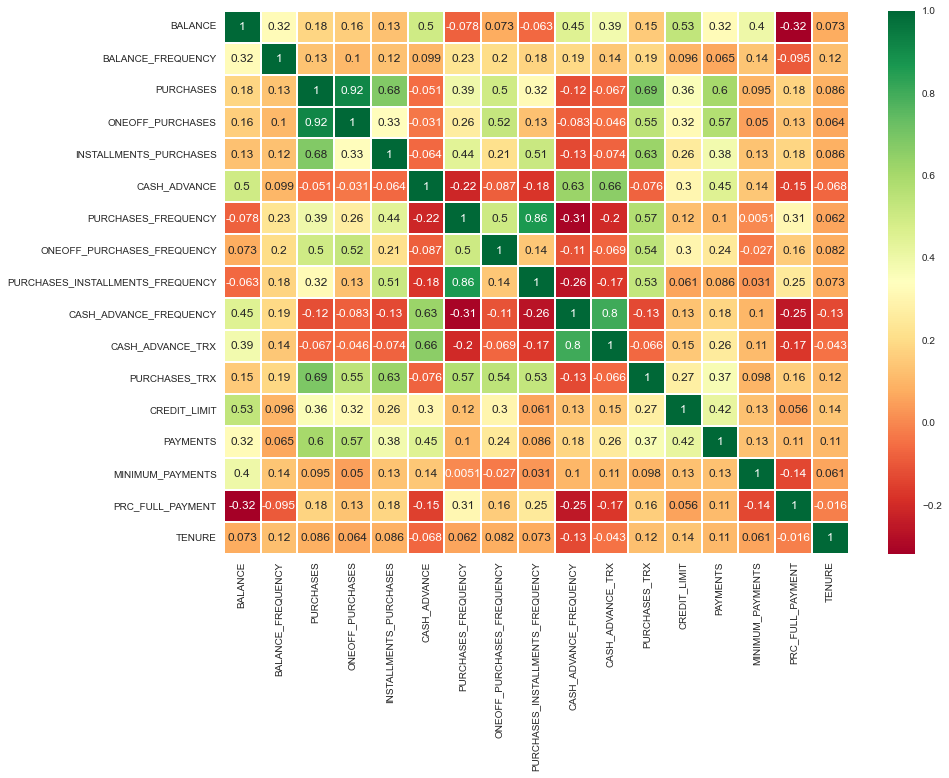

In [10]:
# Let's look at the correlation between our features
corr=df.corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr, annot=True, cmap='RdYlGn', linewidths=0.05)
plt.show()

# Data preprocessing

## Dealing with outliers

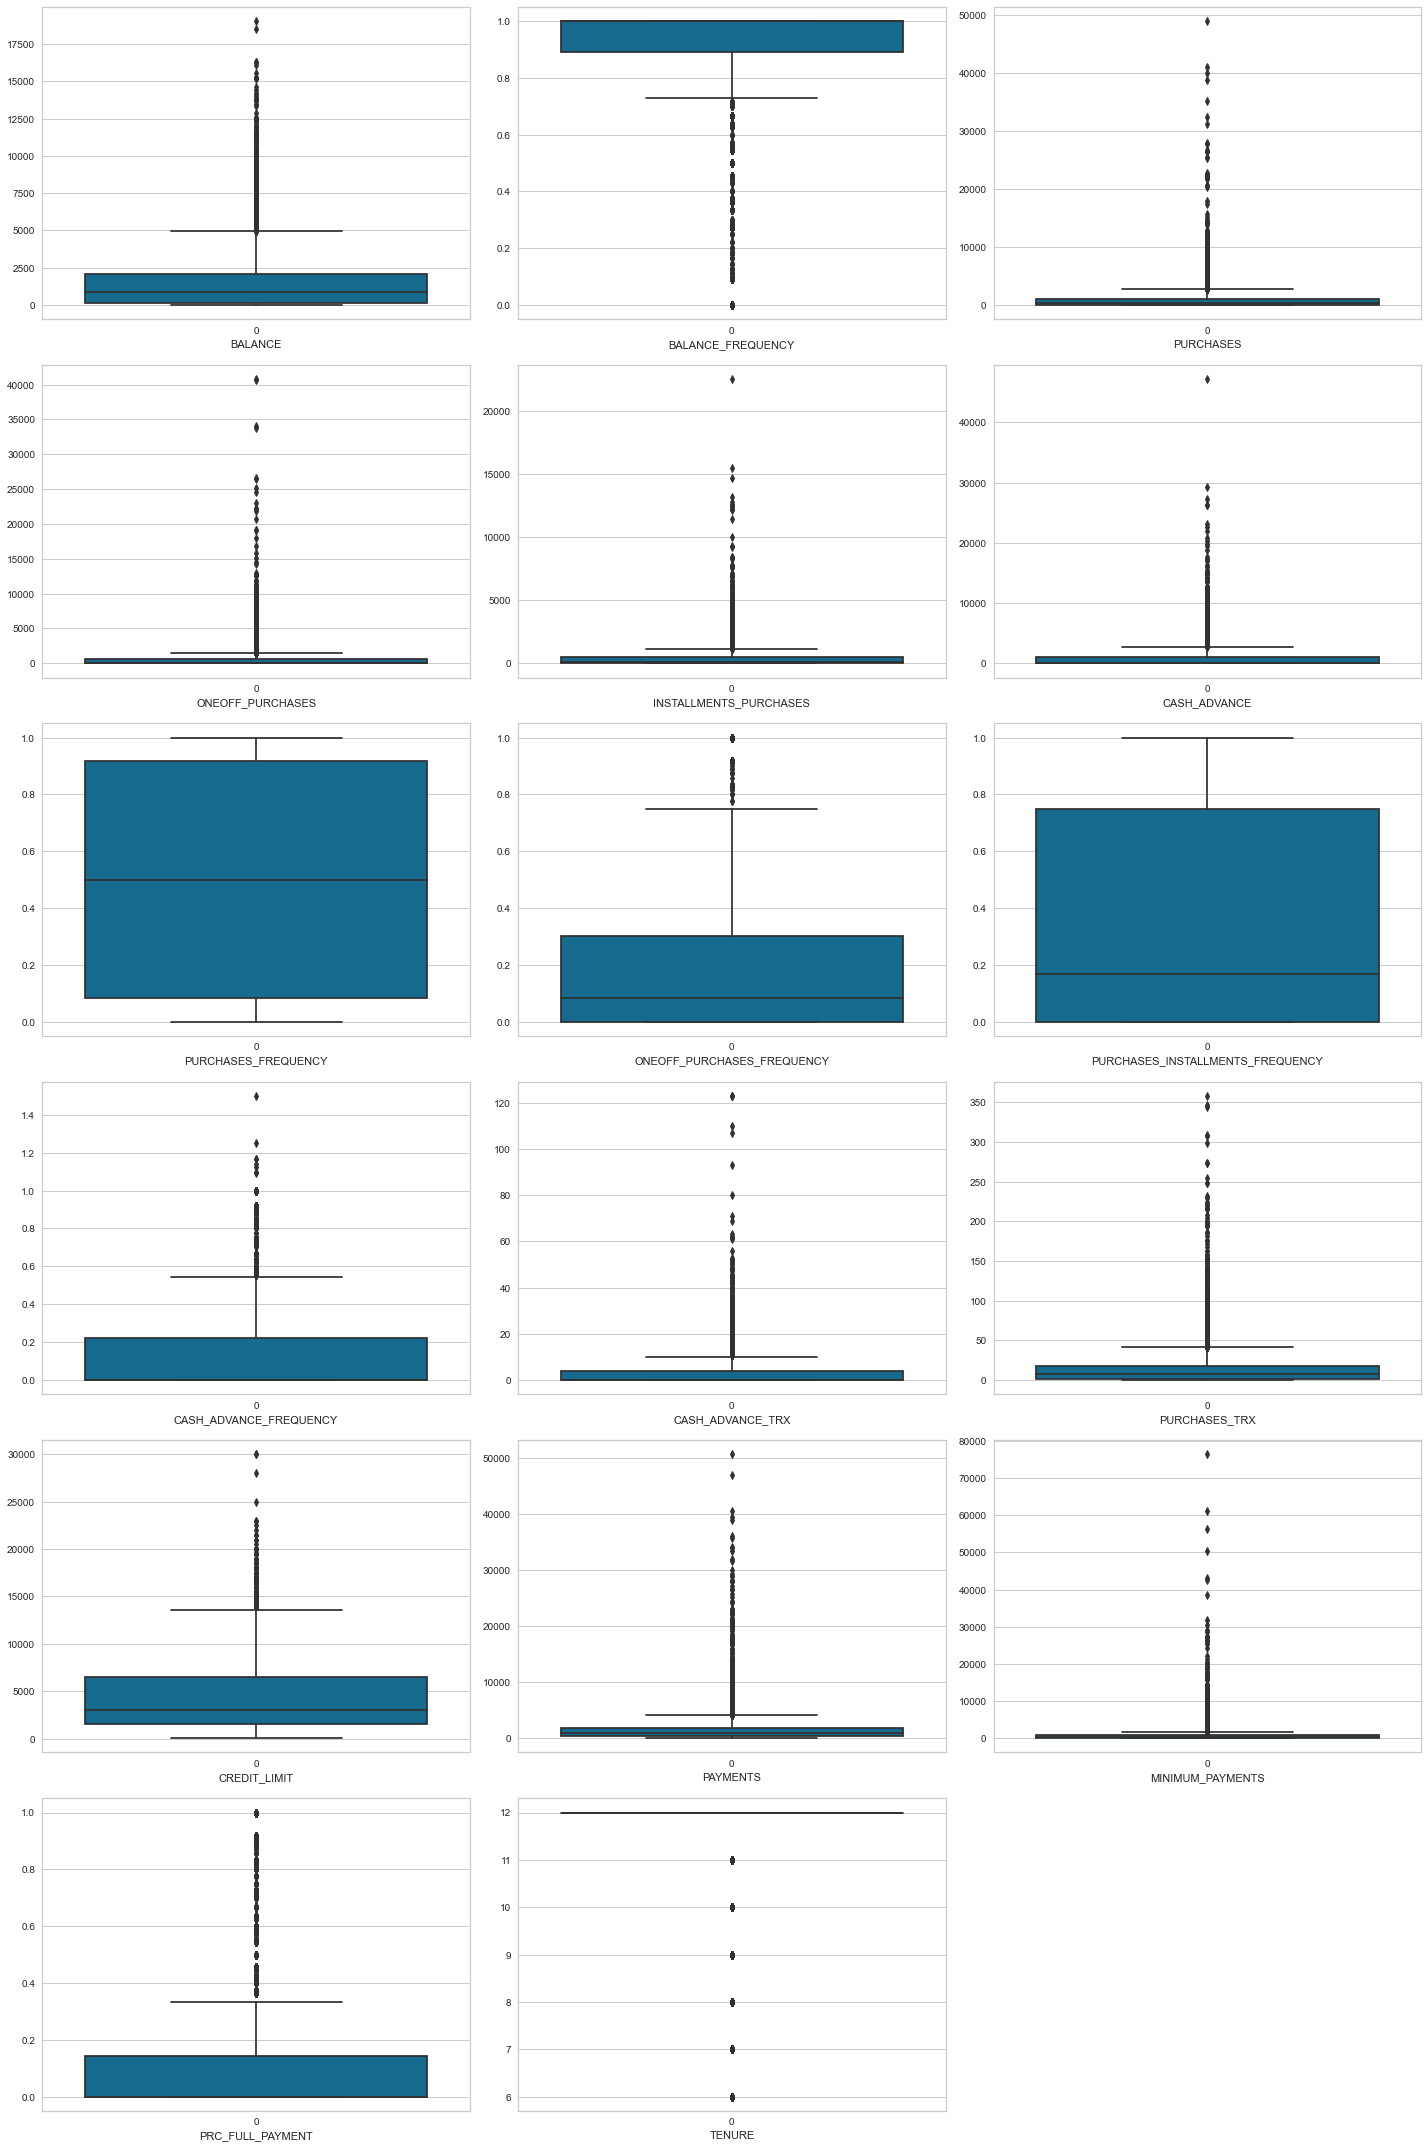

In [11]:
# Let's check the outliers from boxplots

plt.figure(figsize=(20, 30))

for i, col in enumerate(df.columns):
    ax = plt.subplot(6, 3, i+1)
    sns.boxplot(data=df[col], ax=ax)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [12]:
# At first I'll set all outliers as NaN, then impute the missing values

for col in df.columns:

    data = df[col]
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)

    IQR = Q3 - Q1

    min = Q1 - (1.5 * IQR)
    max = Q3 + (1.5 * IQR)
 
    outliers = ( (data < min) | (data > max) )

    df.loc[outliers, col] = np.nan
    
df.isna().sum()

BALANCE                              695
BALANCE_FREQUENCY                   1493
PURCHASES                            808
ONEOFF_PURCHASES                    1013
INSTALLMENTS_PURCHASES               867
CASH_ADVANCE                        1030
PURCHASES_FREQUENCY                    0
ONEOFF_PURCHASES_FREQUENCY           782
PURCHASES_INSTALLMENTS_FREQUENCY       0
CASH_ADVANCE_FREQUENCY               525
CASH_ADVANCE_TRX                     804
PURCHASES_TRX                        766
CREDIT_LIMIT                         248
PAYMENTS                             808
MINIMUM_PAYMENTS                     889
PRC_FULL_PAYMENT                    1474
TENURE                              1366
dtype: int64

In [13]:
# impute missing values with KNNImputer
imputer = KNNImputer()
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df.isna().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [14]:
df.describe().T

count         mean          std        min  \
BALANCE                           8950.0  1237.212469  1274.969848   0.000000   
BALANCE_FREQUENCY                 8950.0     0.977871     0.060313   0.727273   
PURCHASES                         8950.0   613.495032   673.214654   0.000000   
ONEOFF_PURCHASES                  8950.0   230.735476   345.414742   0.000000   
INSTALLMENTS_PURCHASES            8950.0   224.516034   285.143437   0.000000   
CASH_ADVANCE                      8950.0   453.778455   699.480792   0.000000   
PURCHASES_FREQUENCY               8950.0     0.490351     0.401371   0.000000   
ONEOFF_PURCHASES_FREQUENCY        8950.0     0.169208     0.227268   0.000000   
PURCHASES_INSTALLMENTS_FREQUENCY  8950.0     0.364437     0.397448   0.000000   
CASH_ADVANCE_FREQUENCY            8950.0     0.105138     0.140730   0.000000   
CASH_ADVANCE_TRX                  8950.0     1.764089     2.587475   0.000000   
PURCHASES_TRX                     8950.0    10.416916    10.778643   0.000000   
CREDIT_LIMIT                      8950.0  4283.004260  3103.077276  50.000000   
PAYMENTS                          8950.0  1193.752466  1001.170044   0.000000   
MINIMUM_PAYMENTS                  8950.0   492.449844   434.803317   0.019163   
PRC_FULL_PAYMENT                  8950.0     0.031516     0.070108   0.000000   
TENURE                            8950.0    12.000000     0.000000  12.000000   

                                          25%          50%          75%  \
BALANCE                            128.281915   868.895628  1956.016452   
BALANCE_FREQUENCY                    1.000000     1.000000     1.000000   
PURCHASES                           39.550000   360.000000  1027.622500   
ONEOFF_PURCHASES                     0.000000    27.935000   357.342000   
INSTALLMENTS_PURCHASES               0.000000    89.000000   375.172500   
CASH_ADVANCE                         0.000000     0.000000   830.859029   
PURCHASES_FREQUENCY                  0.083333     0.500000     0.916667   
ONEOFF_PURCHASES_FREQUENCY           0.000000     0.083333     0.266667   
PURCHASES_INSTALLMENTS_FREQUENCY     0.000000     0.166667     0.750000   
CASH_ADVANCE_FREQUENCY               0.000000     0.000000     0.166667   
CASH_ADVANCE_TRX                     0.000000     0.000000     3.000000   
PURCHASES_TRX                        1.000000     7.000000    17.000000   
CREDIT_LIMIT                      1600.000000  3000.000000  6300.000000   
PAYMENTS                           383.276166   856.468331  1871.536439   
MINIMUM_PAYMENTS                   166.310858   298.657981   751.360429   
PRC_FULL_PAYMENT                     0.000000     0.000000     0.016667   
TENURE                              12.000000    12.000000    12.000000   

                                           max  
BALANCE                            4940.113918  
BALANCE_FREQUENCY                     1.000000  
PURCHASES                          2711.900000  
ONEOFF_PURCHASES                   1443.330000  
INSTALLMENTS_PURCHASES             1170.490000  
CASH_ADVANCE                       2784.294727  
PURCHASES_FREQUENCY                   1.000000  
ONEOFF_PURCHASES_FREQUENCY            0.750000  
PURCHASES_INSTALLMENTS_FREQUENCY      1.000000  
CASH_ADVANCE_FREQUENCY                0.545455  
CASH_ADVANCE_TRX                     10.000000  
PURCHASES_TRX                        41.000000  
CREDIT_LIMIT                      13600.000000  
PAYMENTS                           4177.324826  
MINIMUM_PAYMENTS                   1757.148202  
PRC_FULL_PAYMENT                      0.333333  
TENURE                               12.000000

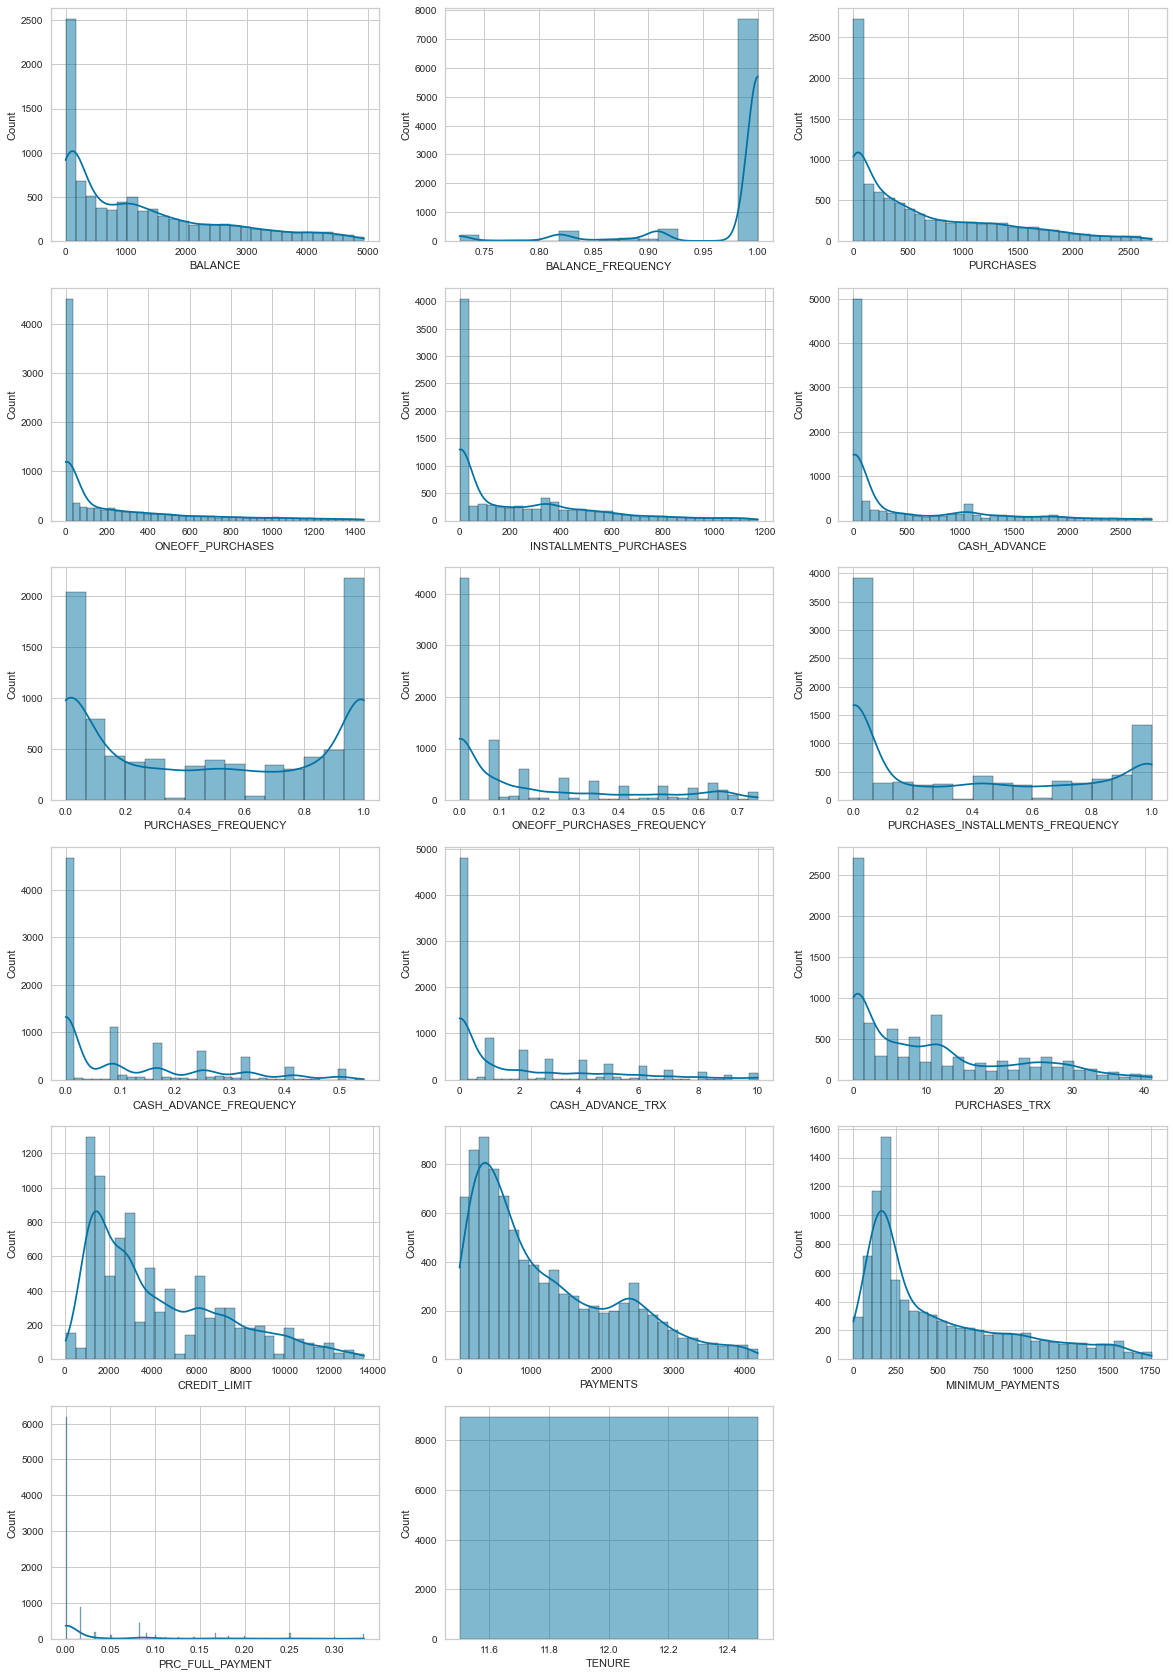

In [15]:
# Let's check the distributions of our features

plt.figure(figsize=(20,30))

for i, col in enumerate(df.columns):
        ax = plt.subplot(6, 3, i+1)
        sns.histplot(df[col] , ax=ax , kde=True)
        plt.xlabel(col)

plt.show()

In [16]:
# TENURE column has now only one value
df['TENURE'].value_counts()

12.0    8950
Name: TENURE, dtype: int64

In [17]:
# It won't play any role in determining the clusters, I'll drop it:
df.drop('TENURE', axis=1, inplace=True)

## Applying Log Transformation to handle the Skewness in our features

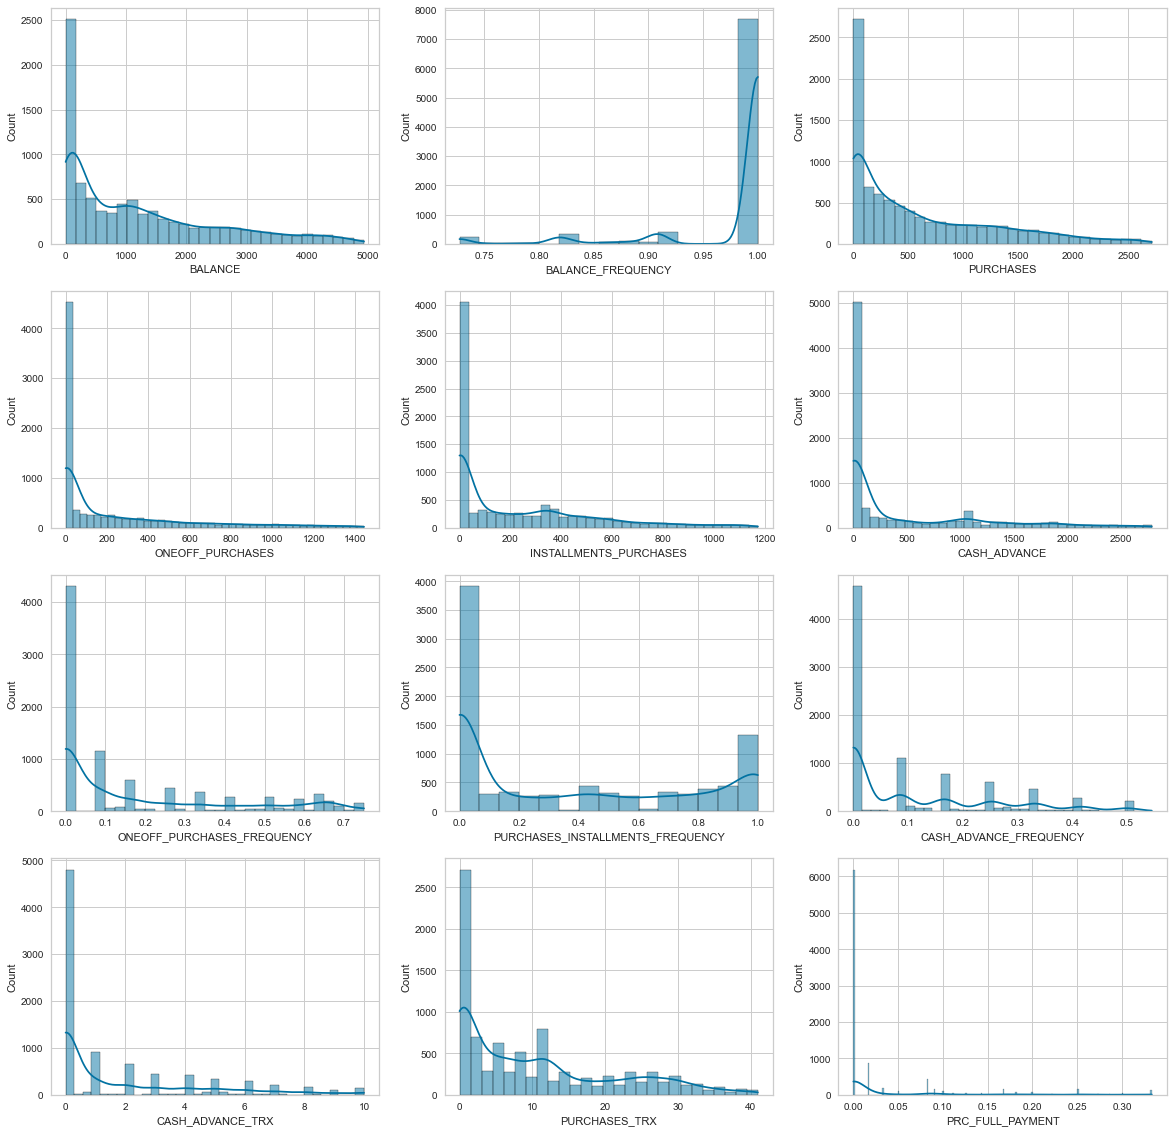

In [18]:
Skewed_Columns = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'PRC_FULL_PAYMENT']

# Let's check the distributions of skewed features

plt.figure(figsize=(20,20))

for i, col in enumerate(df[Skewed_Columns]):

        ax = plt.subplot(4, 3, i+1)
        sns.histplot(df[col] , ax=ax , kde=True)
        plt.xlabel(col)

plt.show()

In [19]:
# Let's apply log transformation

log_df = df.copy()

for col in Skewed_Columns:
    log_df[col] = np.log(1 + log_df[col])

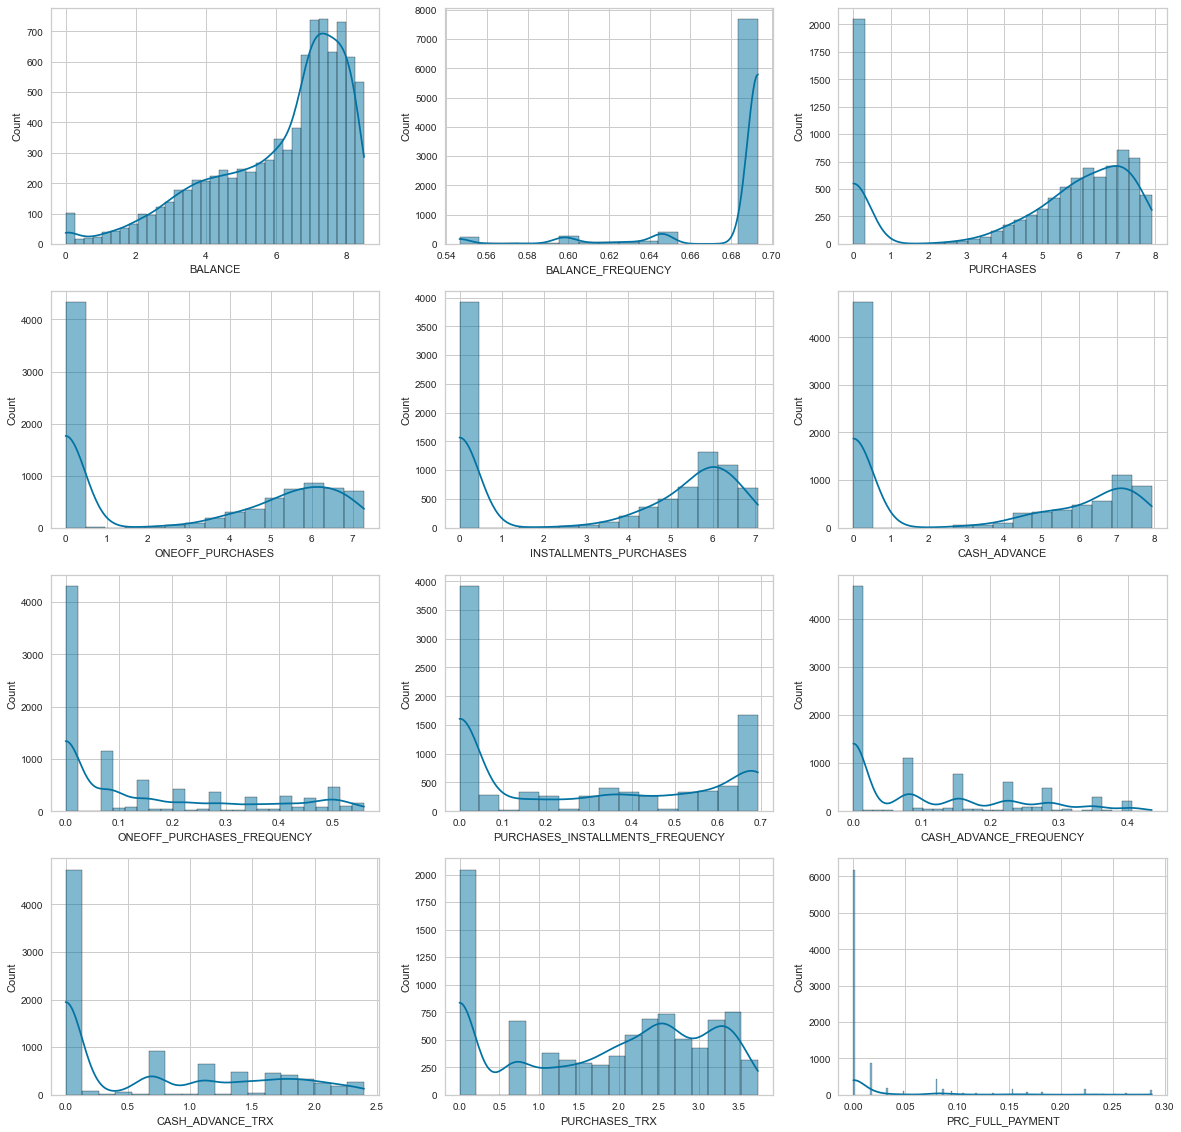

In [20]:
plt.figure(figsize=(20,20))

for i, col in enumerate(log_df[Skewed_Columns]):
        ax = plt.subplot(4, 3, i+1)
        sns.histplot(log_df[col] , ax=ax , kde=True)
        plt.xlabel(col)
        
plt.show()

## Standardizing features

In [21]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(log_df)

In [22]:
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0    -1.217719          -2.621451  -0.075470         -0.996559   
1     1.024713          -1.093178  -1.712894         -0.996559   
2     0.895708           0.363986   0.671212          1.270965   
3     0.687157           0.077926   0.908278          0.749861   
4     0.319278           0.363986  -0.697426         -0.030747   
...        ...                ...        ...               ...   
8945 -1.399285           0.363986   0.321890         -0.996559   
8946 -1.595424           0.363986   0.332623         -0.996559   
8947 -1.497345          -2.361513   0.071832         -0.996559   
8948 -1.767941          -2.361513  -1.712894         -0.996559   
8949 -0.086250           0.363986   0.795236          1.388924   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                   0.472224     -0.916841            -0.806490   
1                  -1.103623      1.201508            -1.221758   
2                  -1.103623     -0.916841             1.269843   
3                  -1.103623      0.702520            -1.014125   
4                  -1.103623     -0.916841            -1.014125   
...                      ...           ...                  ...   
8945                0.854641     -0.916841             1.269843   
8946                0.864971     -0.916841             1.269843   
8947                0.613987     -0.916841             0.854576   
8948               -1.103623      0.184432            -1.221758   
8949               -1.103623      0.556930             0.439310   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                      -0.782910                         -0.674253   
1                      -0.782910                         -0.958256   
2                       2.027457                         -0.958256   
3                      -0.333709                         -0.958256   
4                      -0.333709                         -0.958256   
...                          ...                               ...   
8945                   -0.782910                          1.192408   
8946                   -0.782910                          1.192408   
8947                   -0.782910                          0.854234   
8948                   -0.782910                         -0.958256   
8949                    2.083861                         -0.958256   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                  -0.773031         -0.823824      -0.572307     -1.058043   
1                   1.091585          1.185151      -1.450590      0.875630   
2                  -0.773031         -0.823824       0.599953      1.036769   
3                  -0.104186          0.041394      -0.896455      1.036769   
4                  -0.773031         -0.823824      -0.896455     -0.993587   
...                      ...               ...            ...           ...   
8945               -0.773031         -0.823824       0.105063     -1.058043   
8946               -0.773031         -0.823824       0.105063     -1.058043   
8947               -0.773031         -0.823824      -0.018172     -1.058043   
8948                0.515074          0.547515      -1.450590     -1.219182   
8949                1.630875          0.547515       1.090097     -0.993587   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  
0    -0.990846         -0.811769         -0.461893  
1     2.906042          1.333759          2.739015  
2    -0.571050          0.310123         -0.461893  
3    -1.192424         -0.259028         -0.461893  
4    -0.514844         -0.569619         -0.461893  
...        ...               ...               ...  
8945 -0.867192         -1.020204         -0.198234  
8946 -0.916870         -0.773703         -0.461893  
8947 -1.111244         -0.943080          3.097484  
8948 -1.139932         -1.004405          3.097484  
8949 -1.129329         -0.929578    

## Dimensionality Reduction with PCA

In [23]:
# First, I will Make Componentes to all features in the data.

pca = PCA()

X_pca = pca.fit_transform(df_scaled)

In [24]:
# Convert to dataframe

component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]

X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.090395 -3.079695 -0.101880  0.632189 -0.157147  2.415324  0.203278   
1  3.618121  1.716727  0.377783  3.032004  2.746553 -0.233458  1.305362   
2 -1.555827  1.115112 -2.619530 -1.046306 -0.101829  0.026187  0.158936   
3  1.251319  0.106721 -1.527086 -0.619657 -0.173599  0.271551 -0.605630   
4  1.039878 -1.788606 -1.407736 -0.961668  0.094021 -0.145429  0.860871   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -0.227476  0.357427  0.033689  0.142951 -0.456060  0.693260 -0.031168   
1 -0.469216  0.038089  0.297728  0.030067 -0.045340 -0.193476 -0.138764   
2  0.903451 -1.134692  0.425557  0.360892  0.798674  0.066562 -0.065567   
3  1.155975  0.518178 -1.251970 -0.340630  0.756981  0.223907  0.295172   
4 -0.500234 -0.351751 -0.529202  0.215703 -0.000143 -0.187462 -0.099363   

       PC15      PC16  
0  0.087054  0.108795  
1 -0.031576  0.065917  
2  0.171632  0.546854  
3  0.641135 -0.234756  
4 -0.046693 -0.050967

In [25]:
# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

In [26]:
cum_sum_eigenvalues

array([0.35888733, 0.54900162, 0.65226994, 0.73072997, 0.79419466,
       0.85096638, 0.8936869 , 0.92732447, 0.94626035, 0.9632375 ,
       0.97363711, 0.982994  , 0.99112896, 0.99556384, 0.9980272 ,
       1.        ])

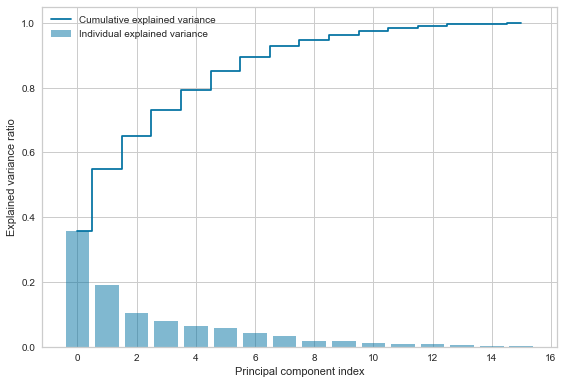

In [27]:
# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

    About 90% of the Variance in the data is explained by only 7 components.

    About 95% of the variance in the data is explained by only 9 components.

# Clustering - scaled data

In [28]:
def show_elbow_visualization(data, k_range=(1, 11), random_state=0):
    """
    Show the elbow visualization to determine the optimal number of clusters for KMeans.

    Parameters:
        data (pd.DataFrame or array-like): The data for clustering.
        k_range (tuple, optional): The range of k values to test. Defaults to (1, 11).
        random_state (int, optional): Random seed for reproducibility. Defaults to 0.
    """
    
    kmeans = KMeans(random_state=random_state)

    vis_elbow = KElbowVisualizer(kmeans, k=k_range)
    vis_elbow.fit(data)
    vis_elbow.poof()

C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\HP\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

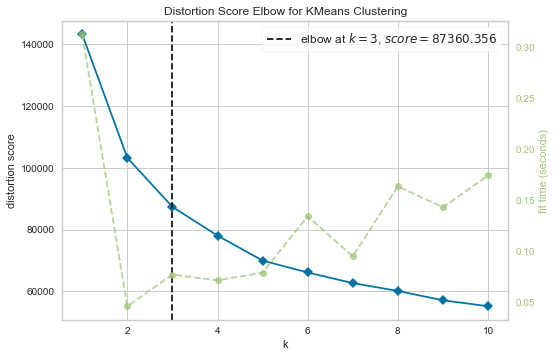

In [29]:
show_elbow_visualization(df_scaled, k_range=(1, 11), random_state=0)

    Seems Like Customers can be grouped to 3 or 4 Clusters.

In [30]:
def show_silhouette_visualization(data, n_clusters=range(2, 11), random_state=0):
    """
    Show the silhouette scores visualization to determine the optimal number of clusters for KMeans.

    Parameters:
        data (pd.DataFrame or array-like): The data for clustering.
        k_range (tuple, optional): The range of k values to test. Defaults to (2, 11).
        random_state (int, optional): Random seed for reproducibility. Defaults to 0.
    """    

    score=[]

    for n in n_clusters:
        km = KMeans(n_clusters=n, random_state=random_state)
        km.fit_predict(data)
        score.append(silhouette_score(data, km.labels_, metric='euclidean'))

    # Plot n_clusters vs silhouette scores
    fig, ax = plt.subplots()
    ax.plot(n_clusters, score, '-o')
    ax.set_xlabel('number of clusters, k')
    ax.set_ylabel('silhouette_score')
    ax.set_title('silhouette scores for different number of clusters')
    ax.set_xticks(n_clusters)
    plt.show()

C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

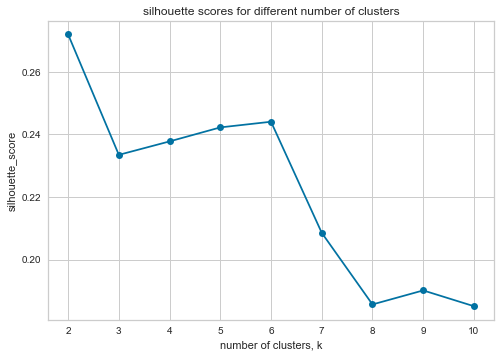

In [31]:
show_silhouette_visualization(df_scaled, n_clusters=range(2, 11), random_state=0)

In [32]:
def show_silhouette_plots(data, n_clusters=range(2, 6), random_state=0):
    """
    Show the silhouette plot to determine the optimal number of clusters for KMeans.

    Parameters:
        data (pd.DataFrame or array-like): The data for clustering.
        k_range (tuple, optional): The range of k values to test. Defaults to (2, 11).
        random_state (int, optional): Random seed for reproducibility. Defaults to 0.
    """    
    fig, ax = plt.subplots()
    for k in n_clusters:
        model = KMeans(k, random_state=random_state)
        visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
        visualizer.fit(data)        
        visualizer.show()        

C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


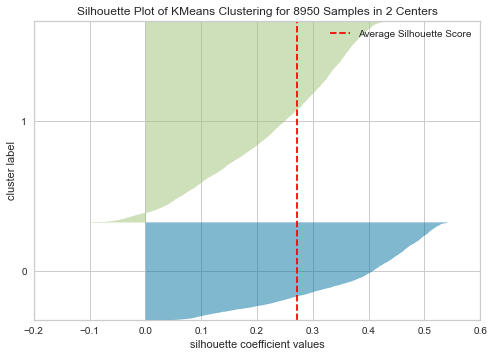

C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


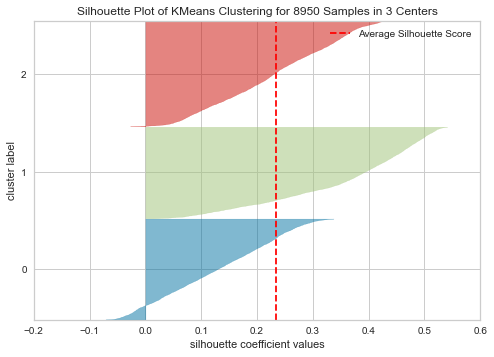

C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


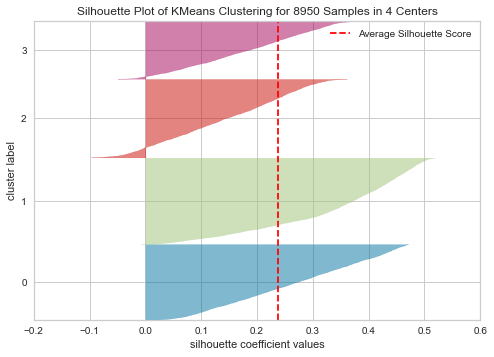

C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


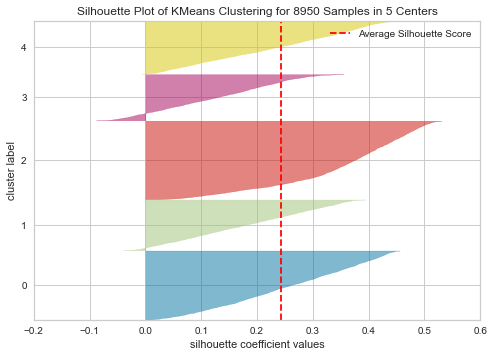

In [33]:
show_silhouette_plots(df_scaled, n_clusters=range(2, 6), random_state=0)

    The biggest silhouette score is for 2 clusters, but the groups are not evenly distributed.
    
    For 3 and 4 clusters silhouette score is similar and the groups are evenly distributed.
    
    Similar silhouette score to 3-4 clusters is for 5 clusters, but the groups are not evenly distributed.

# Clustering - data after dimensionality reduction

In [34]:
# I will reduce the number of features to 9
pca = PCA(n_components=9, random_state=0)

X_pca_9 = pca.fit_transform(df_scaled)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

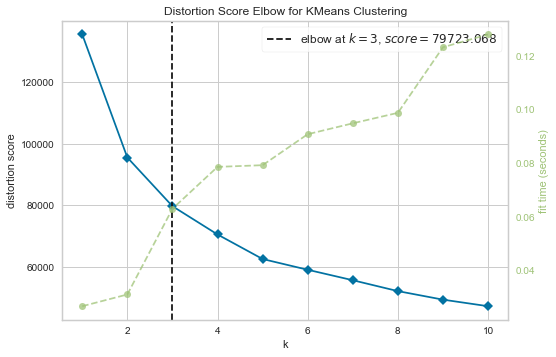

In [35]:
show_elbow_visualization(X_pca_9, k_range=(1, 11), random_state=0)

    Same result as for scaled data - Customers can be grouped to 3 or 4 Clusters.

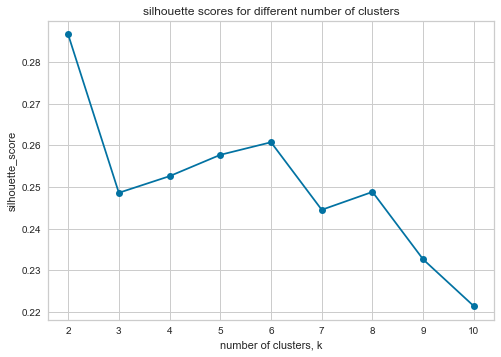

In [55]:
show_silhouette_visualization(X_pca_9, n_clusters=range(2, 11), random_state=0)

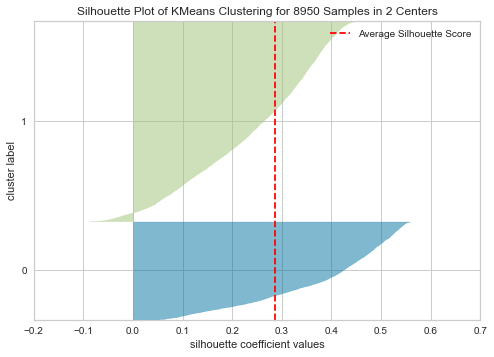

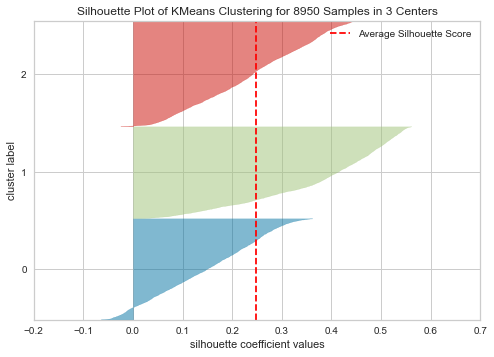

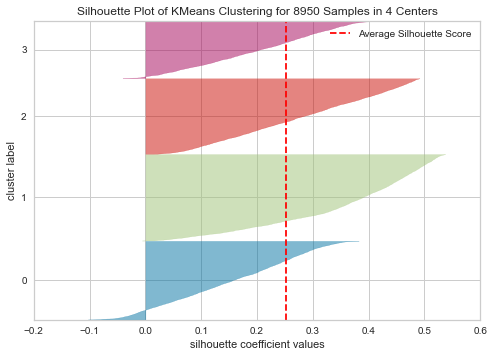

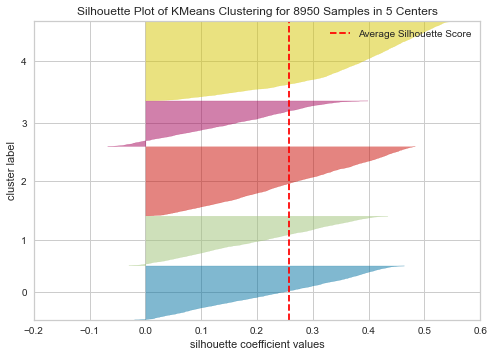

In [61]:
show_silhouette_plots(X_pca_9, n_clusters=range(2, 6), random_state=0)

    Similar results as for scaled data.
    
    For 3 and 4 clusters silhouette score are similar and the groups are evenly distributed. 
    
    Customers can be grouped to 3 or 4 Clusters

#### I choose 3 clusters for the analysis as the best choice

## Visualizing Clusters

In [28]:
kmeans = KMeans(n_clusters = 3, random_state=0)

pca_labels = kmeans.fit_predict(X_pca)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\HP\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


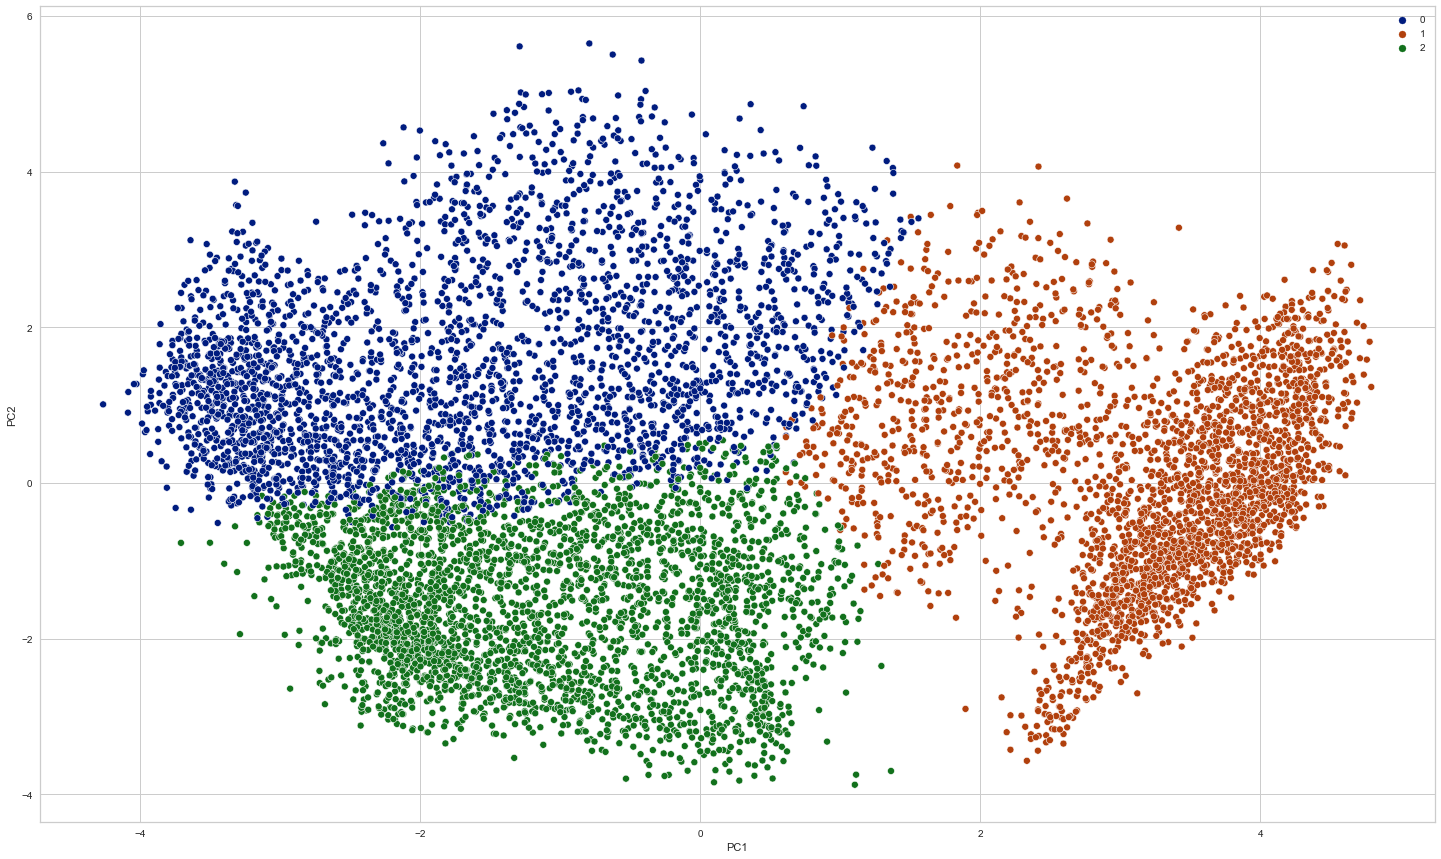

In [29]:
# 2d visualization
plt.figure(figsize=(25,15))

ax = sns.scatterplot(x= X_pca["PC1"], y= X_pca["PC2"], hue = pca_labels, data = X_pca, palette='dark')

plt.show()

In [30]:
# 3d visualization
fig = px.scatter_3d( X_pca, x= X_pca["PC1"], y= X_pca["PC2"], z = X_pca["PC3"] , color = pca_labels)

fig.show()

In [31]:
# create model with 3 clusters
kmean= KMeans(3, random_state=0)
kmean.fit(df_scaled)
labels=kmean.labels_

# create new dataframe with clusters
clusters=pd.concat([df, pd.DataFrame({'cluster':labels})], axis=1)
clusters.head()

C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0    40.900749           0.818182      95.40              0.00   
1  3202.467416           0.909091       0.00              0.00   
2  2495.148862           1.000000     773.17            773.17   
3  1666.670542           0.981818    1499.00            166.86   
4   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   1068.127248             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    0.650000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000               0.0            2.0        1000.0   
1                0.250000               4.0            0.0        7000.0   
2                0.000000               0.0           12.0        7500.0   
3                0.083333               1.0            1.0        7500.0   
4                0.000000               0.0            1.0        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  cluster  
0   201.802084        139.509787          0.000000        2  
1  4103.032597       1072.340217          0.222222        1  
2   622.066742        627.284787          0.000000        0  
3     0.000000        379.829982          0.000000        1  
4   678.334763        244.791237          0.000000        2

###  Interpretation of Clusters

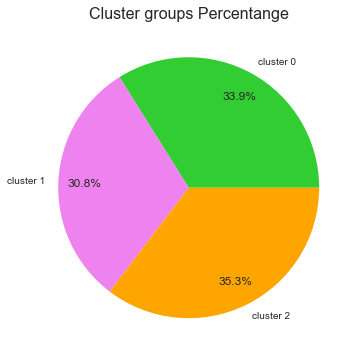

In [32]:
# create pie chart
clas = dict(clusters.groupby('cluster')['cluster'].count())
labels = ['cluster 0', 'cluster 1', 'cluster 2']
colors = ['limegreen', 'violet', 'orange']
values = clas.values()
plt.figure(figsize=(6,6))
plt.pie(data=df, x=values, labels=labels, autopct = '%1.1f%%', pctdistance=0.8, colors=colors)
plt.title('Cluster groups Percentange', fontsize=16)
plt.show()

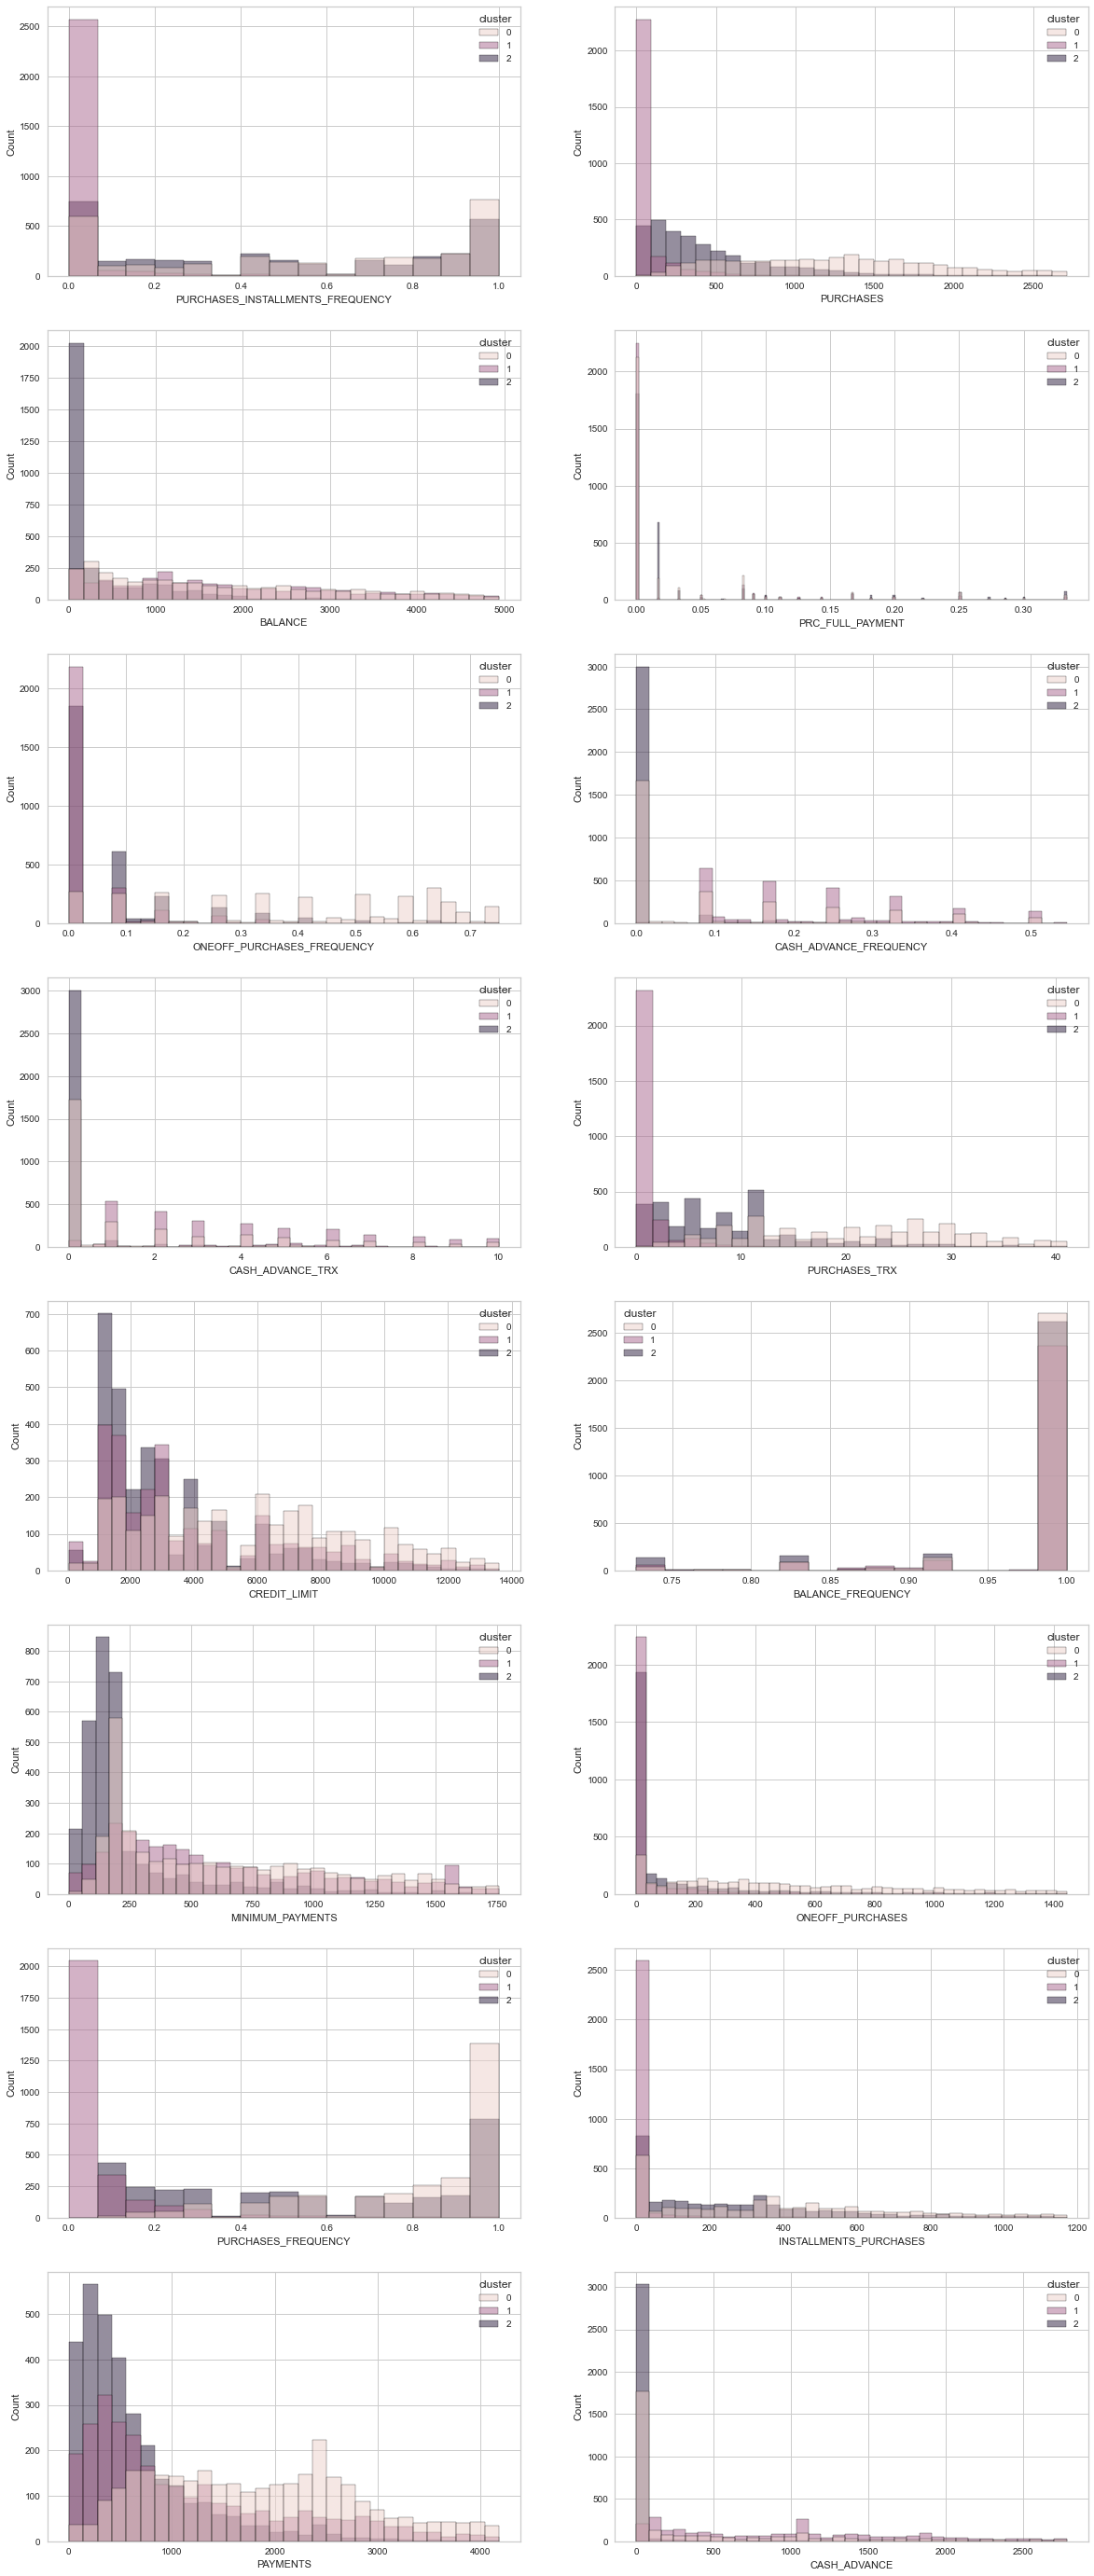

In [38]:
nrows = 8
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 50))
col_list = list(clusters.columns)
col_list = list(set(col_list) - set(['cluster']))
col = 0

for i in range(nrows):
    for j in range(ncols):
        sns.histplot(data=clusters, x=col_list[col], hue='cluster', ax=axes[i, j], color=colors)
        col = col + 1

## Cluster 0 :

        Customers with Medium Balance, Update their Balance More Frequently.

        With Medium Purchases Amount and pay more in Single Transaction, Prefer more Installment Purchases.

        Purchase More Frequently with High Payments and they have a High Credit Limit.


## Cluster 1 :

        Customers with Above Medium Balance.

        Doesn't Prefer Installment Purchases , But Prefer to Pay in advance.

        Doesn't Purchase Frequently but when they do it's with Medium Payments and they have a Medium Credit Limit.


## Cluster 2 :

        Customers with lowest balance.

        May Make Installment Purchases and doesn't Prefer Paying in Advance.

        Purchase Frequently with Low Payments and they have a Low Credit Limit.

